In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error

In [15]:
data=pd.read_csv('./data/USD_KRW.csv')
data.columns=['ds','y']
data=data.set_index('ds')

#### 정리 세팅

#### 1. 날짜 정리

In [16]:
start_date_train = '2018-02-01'
end_date_train = '2019-01-31'
start_date_test = '2019-02-01'
end_date_test = '2019-02-28'

#### 2. 휴일정리

In [17]:
train_holiday = ['2018-02-03','2018-02-04','2018-02-10','2018-02-11','2018-02-15','2018-02-16','2018-02-17',
       '2018-02-18','2018-02-24','2018-02-25','2018-03-01','2018-03-03','2018-03-04','2018-03-10','2018-03-11',
       '2018-03-17','2018-03-18','2018-03-24','2018-03-25','2018-03-31','2018-04-01','2018-04-07','2018-04-08',
       '2018-04-14','2018-04-15','2018-04-21','2018-04-22','2018-04-28','2018-04-29','2018-05-05','2018-05-06',
       '2018-05-07','2018-05-12','2018-05-13','2018-05-19','2018-05-20','2018-05-22','2018-05-26','2018-05-27',
       '2018-06-02','2018-06-03','2018-06-06','2018-06-09','2018-06-10','2018-06-13','2018-06-16','2018-06-17',
       '2018-06-23','2018-06-24','2018-06-30','2018-07-01','2018-07-07','2018-07-08','2018-07-14','2018-07-15',
       '2018-07-21','2018-07-22','2018-07-28','2018-07-29','2018-08-04','2018-08-05','2018-08-12','2018-08-15',
       '2018-08-18','2018-08-19','2018-08-25','2018-08-26','2018-09-01','2018-09-02','2018-09-08','2018-09-09',
       '2018-09-15','2018-09-16','2018-09-22','2018-09-23','2018-09-24','2018-09-25','2018-09-29','2018-09-30',
       '2018-10-03','2018-10-06','2018-10-07','2018-10-09','2018-10-13','2018-10-14','2018-10-20','2018-10-21',
       '2018-10-27','2018-10-28','2018-11-03','2018-11-04','2018-11-10','2018-11-11','2018-11-17','2018-11-18',
       '2018-11-24','2018-11-25','2018-12-01','2018-12-02','2018-12-08','2018-12-09','2018-12-15','2018-12-16',
       '2018-12-22','2018-12-23','2018-12-25','2018-12-29','2018-12-30','2019-01-01','2019-01-05','2019-01-06',
       '2019-01-12','2019-01-13','2019-01-19','2019-01-20','2019-01-26','2019-01-27']

test_holiday = ['2019-02-02','2019-02-03','2019-02-04','2019-02-05','2019-02-06','2019-02-09','2019-02-10',
       '2019-02-16','2019-02-17','2019-02-23','2019-02-24']

### 시작

In [18]:
df_train=data.loc[start_date_train : end_date_train, : ]
df_test=data.loc[start_date_test: end_date_test, :]

df_train=df_train.reset_index()
df_test=df_test.reset_index()

#### 1. 예측값의 상한과 하한을 제어

In [19]:
df_train['cap'] = 1250
df_train['floor'] = 1000

#### 2. 객체 생성하고 Fit

In [20]:
# holiday이지만 주말과 공휴일을 다 삭제 
holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(
        train_holiday), 
        'lower_window': 0,
        'upper_window': 0,
        })

m = Prophet(growth='logistic', holidays=holiday,yearly_seasonality=True, changepoint_range=0.9,
           daily_seasonality=True) # 여기서 파라미터 추가, 삭제 
m.fit(df_train)

#### 3. 미래 Dataframe 생성

In [21]:
future = m.make_future_dataframe(periods=31)
future.head()

future=future.set_index('ds')
future_train=future.loc[start_date_train : end_date_train, : ]
future_test=future.loc[start_date_test: end_date_test, :]

future_train=future_train.reset_index()
future_test=future_test.reset_index()

In [22]:
start_date = datetime.strptime(start_date_test, '%Y-%m-%d') #시작 날짜
end_date = datetime.strptime(end_date_test, '%Y-%m-%d') #끝 날짜

test_total_date = [] 

while start_date.strftime('%Y-%m-%d') != end_date.strftime('%Y-%m-%d'):
    test_total_date.append(start_date.strftime('%Y-%m-%d')) 
    start_date += timedelta(days=1)


test_holiday_date=test_holiday    #마찬가지로 주말, 공휴일 제거 추후 추가

In [23]:
final_date = list(set(test_total_date) - set(test_holiday_date))
future_test=future_test[future_test['ds'].isin(final_date)]
future=pd.concat([future_train,future_test],ignore_index=True)

future['cap'] = 1250
future['floor'] = 1000

#### 예측하기

In [24]:
forecast = m.predict(future)  

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-02-01,1079.484605,1072.409000,1086.845275
1,2018-02-02,1081.122845,1073.902450,1088.817867
2,2018-02-05,1082.669046,1075.551763,1090.194403
3,2018-02-06,1082.398562,1075.063477,1089.513030
4,2018-02-07,1083.195313,1076.041863,1090.051263
...,...,...,...,...
256,2019-02-21,1126.191712,1118.919308,1133.279373
257,2019-02-22,1126.569868,1119.276456,1133.582879
258,2019-02-25,1124.876323,1117.548964,1132.380294
259,2019-02-26,1123.760450,1116.454064,1131.344217


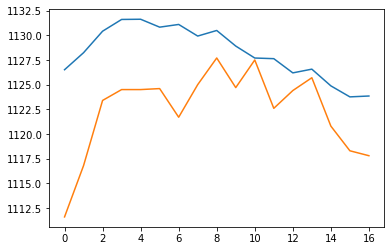

In [25]:
pred=forecast[-len(df_test):].reset_index()

plt.plot(pred['yhat'])
plt.plot(df_test['y'])
plt.show()

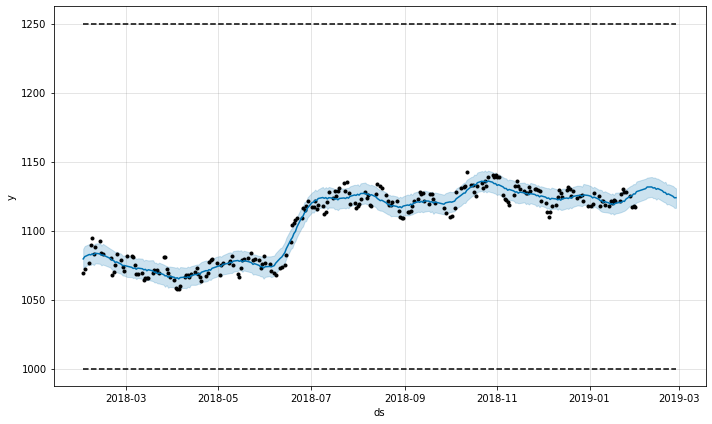

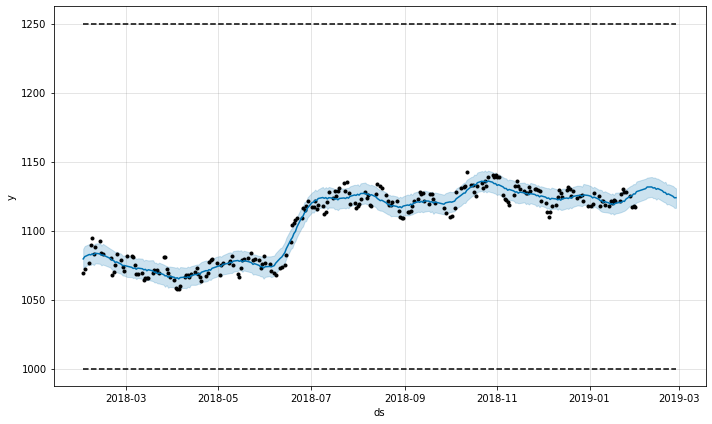

In [26]:
m.plot(forecast)